## Import Libraries

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output



## Data Loading

In [125]:
file_path = '/home/pc/Desktop_linux/chinu/intellimark/Assigment-2-Associate-DS/Assigment-2-Associate-DS/Assessment-2-Associate-DS.csv'
df = pd.read_csv(file_path)
df.head()

,weekend_date,channel,brand,category,sub_category,EAN,quantity
0,2022-06-04,Channel1,B1,Body,Body Lotion,8906087773818,56.0
1,2022-06-11,Channel1,B1,Body,Body Lotion,8906087773818,122.0
2,2022-06-18,Channel1,B1,Body,Body Lotion,8906087773818,102.0
3,2022-06-25,Channel1,B1,Body,Body Lotion,8906087773818,128.0
4,2022-07-02,Channel1,B1,Body,Body Lotion,8906087773818,97.0


In [126]:
df['EAN'].value_counts()

EAN
8906087773818    118
8904417301076    110
8906087779247    109
8904417301106    106
8904417305838     85
8904417306248     72
Name: count, dtype: int64

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekend_date  600 non-null    object 
 1   channel       600 non-null    object 
 2   brand         600 non-null    object 
 3   category      600 non-null    object 
 4   sub_category  600 non-null    object 
 5   EAN           600 non-null    int64  
 6   quantity      600 non-null    float64
dtypes: float64(1), int64(1), object(5)
memory usage: 32.9+ KB


In [128]:
# Convert datatype of date column
NUM_LAST_MONTHS = 3

df['weekend_date'] = df['weekend_date'].apply(lambda x: pd.to_datetime(x.split(' ')[0]))
df = df.sort_values(by='weekend_date', ascending=True).reset_index(drop=True)
df.head()

,weekend_date,channel,brand,category,sub_category,EAN,quantity
0,2022-05-28,Channel2,B1,Face,Face Serum,8906087779247,203.0
1,2022-06-04,Channel2,B1,Face,Face Serum,8906087779247,198.0
2,2022-06-04,Channel1,B1,Body,Body Lotion,8906087773818,56.0
3,2022-06-11,Channel2,B1,Face,Face Serum,8906087779247,188.0
4,2022-06-11,Channel1,B1,Body,Body Lotion,8906087773818,122.0


In [129]:
df.tail()

,weekend_date,channel,brand,category,sub_category,EAN,quantity
595,2024-08-31,Channel2,B2,Face,Face Cleanser,8904417301076,180.0
596,2024-08-31,Channel3,B1,Face,Face Serum,8904417301106,261.0
597,2024-08-31,Channel2,B1,Face,Face Serum,8904417305838,1189.0
598,2024-08-31,Channel1,B1,Body,Body Lotion,8906087773818,78.0
599,2024-08-31,Channel2,B2,Face,Face Cleanser,8904417306248,634.0


## Data Inconsistency:  
- The dates in 'weekend_date' column were incosistent.  
- can not directly apply pd.to_datetime on 'weekend_date' column.  
- Then I spli the string on ' ', and took 1st item for date.

## Handle Missing Values:  
- There were some missing values in the data.  
- I checked whether weekend dates are continuous.  
- If any weekend row is missing, I imputed the missing row quantity by taking average of adjacent 2 weeks' quantity.  

In [130]:
products[8906087779247]['small_df'].tail(50)

,channel,brand,category,sub_category,EAN,quantity,weekend_number,diff_weekend,month_number,target
weekend_date,,,,,,,,,,
2023-09-23,Channel2,B1,Face,Face Serum,8906087779247,993.0,70,1.0,24285,993.0
2023-09-30,Channel2,B1,Face,Face Serum,8906087779247,505.0,71,1.0,24285,505.0
2023-10-07,Channel2,B1,Face,Face Serum,8906087779247,188.0,72,1.0,24286,188.0
2023-10-14,Channel2,B1,Face,Face Serum,8906087779247,184.0,73,1.0,24286,184.0
2023-10-21,Channel2,B1,Face,Face Serum,8906087779247,170.0,74,1.0,24286,170.0
2023-10-28,Channel2,B1,Face,Face Serum,8906087779247,158.0,75,1.0,24286,158.0
2023-11-04,Channel2,B1,Face,Face Serum,8906087779247,203.0,76,1.0,24287,203.0
2023-11-11,Channel2,B1,Face,Face Serum,8906087779247,52.0,77,1.0,24287,52.0
2023-11-18,Channel2,B1,Face,Face Serum,8906087779247,88.0,78,1.0,24287,88.0


In [131]:
# Create small dataframe for given 'EAN' -  product identifier
def create_small_dataframe(df, product_id):
    small_df = df[df['EAN'] == product_id]
    small_df = small_df.reset_index(drop=True)
    small_df = add_missing_month_ifany(small_df)
    small_df = fix_missing_values_ifany(small_df)
    small_df['month_number'] = small_df['weekend_date'].dt.month + small_df['weekend_date'].dt.year * 12  

    return small_df


def fix_missing_values_ifany(small_df):
    ''' 
    need to check all the 'weekend_number' are consecutive.
    '''
    start_date = small_df['weekend_date'].min()
    end_date = small_df['weekend_date'].max()
    small_df['weekend_number'] = small_df['weekend_date'].apply(lambda x: ((x - start_date).days // 7) + 1)
    small_df['diff_weekend'] = small_df['weekend_number'].diff()
    small_df.loc[0, 'diff_weekend'] = 1    

    if (small_df['diff_weekend'] != 1).sum() != 0:
        small_df = add_missing_rows(small_df)
    print('start_date = ', start_date)
    print('End_date = ', end_date)

    return small_df


def add_missing_rows(small_df):
    missing_row_df = small_df[small_df['diff_weekend'] != 1]
    print(f'There are missing values, added {missing_row_df.shape[0]} row in dataframe')
    for i in missing_row_df.index[::-1] :
        new_row = {
                    'weekend_date': [small_df.loc[i, 'weekend_date'] - pd.Timedelta(days=7)],
                    'channel': [small_df.loc[i, 'channel']],
                    'brand': [small_df.loc[i, 'brand']],
                    'category': [small_df.loc[i, 'category']],
                    'sub_category': [small_df.loc[i, 'sub_category']],
                    'EAN': [small_df.loc[i, 'EAN']],
                    'quantity': [(small_df.loc[i, 'quantity'] + small_df.loc[i - 1, 'quantity']) // 2],
                    'weekend_number': [small_df.loc[i, 'weekend_number'] - 1],
                    'diff_weekend': [small_df.loc[i, 'diff_weekend'] - 1]
                }
        new_row_df = pd.DataFrame(new_row)
        df_before = small_df.iloc[:i]
        df_after = small_df.iloc[i:]
        small_df = pd.concat([df_before, new_row_df, df_after], axis=0)
        small_df = small_df.reset_index(drop=True)
    return small_df


def add_missing_month_ifany(small_df): 
    end_date = small_df['weekend_date'].max()
    if end_date != pd.to_datetime('2024-08-31'):
        date_index = pd.date_range(start=pd.to_datetime(end_date) + pd.Timedelta(days=7), end=pd.to_datetime('2024-08-31'), freq='W-SAT') #W-SAT to start on a Saturday.
        new_df = pd.DataFrame({'weekend_date': date_index})
        for column in small_df.columns:
            if column == 'weekend_date':
                continue
            new_df[column] = small_df.iloc[-1][column]
        new_df['quantity'] = 0
        small_df = pd.concat([small_df, new_df])
        small_df = small_df.reset_index(drop=True)
    return small_df


def visualize(small_df):
    plt.figure(figsize=(8,2))
    sns.lineplot(data=small_df, x='weekend_number', y='target')
    plt.xticks(rotation=90)
    plt.title(small_df.loc[0, 'EAN'])
    num_ticks = small_df.shape[0] // 5
    xticks_positions = np.linspace(small_df['weekend_number'].min(), small_df['weekend_number'].max(), num_ticks, dtype=int)
    plt.xticks(xticks_positions)
    plt.show()
    
    plt.figure(figsize=(5,2))
    sns.boxplot(data=small_df, x='quantity')
    plt.show()
    
def ADF_test(data, is_stationary):
    results = adfuller(data)
    p_val = results[1]
    if p_val < 0.05:
        print(f'*** It is a Stationary Data ( P-value is {p_val} ) ***')
        print('Data is ready for Model Building')
        is_stationary = True
    else:
        print(f'It is a non-stationary data ( P-value is {p_val} )')
    return is_stationary


In [132]:
def make_stationary(data, method, is_stationary):
    """
    Transforms time series data to make it stationary.
    """
    try:
        if method == 'differencing':
            stationary_data = data.diff().dropna()  # First-order differencing
        elif method == 'log_differencing':
            stationary_data = np.log(data).diff().dropna() # Log transform, then differencing
        
        else:
            print("Invalid method..")
            return None

        # Check stationarity using ADF test
        is_stationary = ADF_test(stationary_data, is_stationary) 
        return stationary_data, is_stationary

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [ ]:
def acf_and_pacf(data):
    plt.figure(figsize=(3,2))
    plot_acf(data['target'], lags=data.shape[0] // 2, zero=False)
    plt.show()
    plt.figure(figsize=(3,2))
    plot_pacf(data['target'], lags=data.shape[0] // 2, zero=False)
    plt.show()

def split_train_test(data, num_last_months):
    last_month = data['month_number'].max()
    train_size = data[data['month_number'] <= (last_month - num_last_months)].shape[0]
    train_df = data[:train_size]
    test_df = data[train_size:]
    return train_df, test_df

def inverse_transform_pred(train_df, test_df):
    ''' 
    Inintially predictions column is not quantity. Need to transform.
    Save quantity back in predictions column.
    '''
    print(test_df)
    test_df['target'] = test_df['predictions']
    prev_qty = train_df.iloc[-1]['quantity']  # prev_qty is last qty of train data.
    
    for index, row in test_df.iterrows():
        test_df.loc[index, 'predictions'] = prev_qty + row['target']  
        prev_qty = test_df.loc[index, 'predictions']

    print(test_df)
    return test_df

def get_monthly_accuracy(data):
    
    data['abs_diff_in_qty'] = abs(data['predictions'] - data['quantity'])
    agg = pd.DataFrame({})
    agg = data.groupby(by='month_number', as_index=False).agg({'quantity': 'sum', 'abs_diff_in_qty': 'sum', 'predictions':'sum'})
    agg = agg.rename(columns={'quantity': 'total_qty', 'abs_diff_in_qty': 'total_abs', 'predictions':'total_pred_qty'})
    
    # agg['total_abs'] = data.groupby(by='month_number')['abs_diff_in_qty'].sum()
    agg['accuracy'] = 1 - (agg['total_abs'] / agg['total_qty'])

    agg['month'] = agg['month_number'] % 12
    agg['year'] = agg['month_number'] // 12
    
    return agg

## Main Function

product is 8906087779247
There are missing values, added 1 row in dataframe
start_date =  2022-05-28 00:00:00
End_date =  2024-08-31 00:00:00
(119, 10)
*** It is a Stationary Data ( P-value is 1.6527341202601367e-12 ) ***
Data is ready for Model Building


<Figure size 300x200 with 0 Axes>

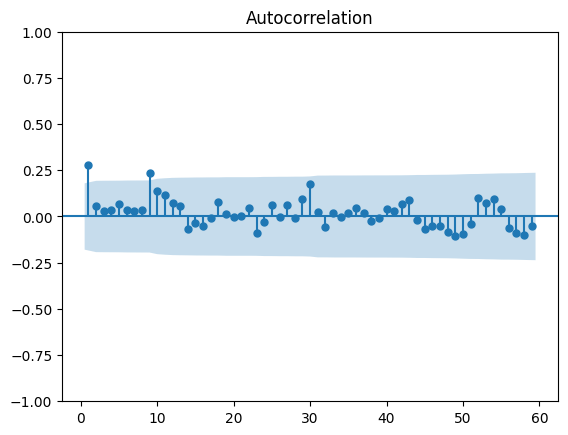

<Figure size 300x200 with 0 Axes>

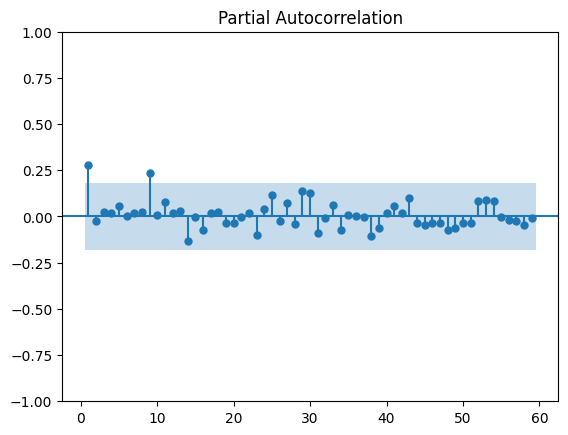

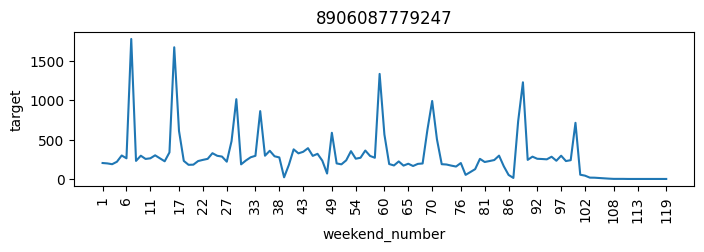

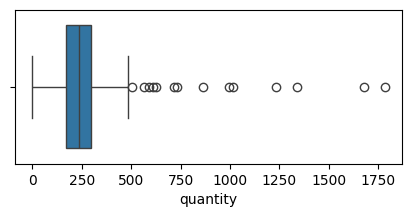

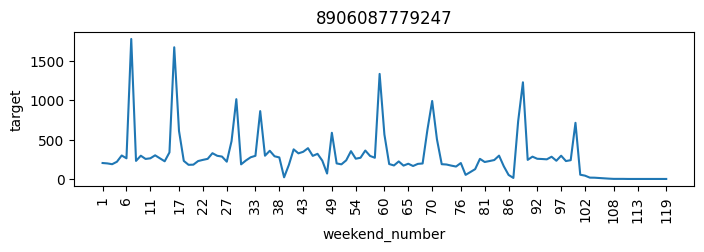

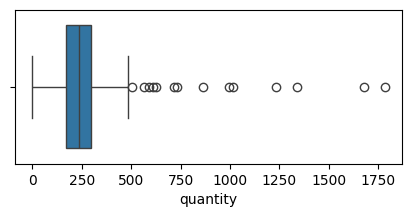

____________________________________________________________________________________________________
product is 8906087773818
start_date =  2022-06-04 00:00:00
End_date =  2024-08-31 00:00:00
(118, 10)
It is a non-stationary data ( P-value is 0.6111353836245638 )


<Figure size 300x200 with 0 Axes>

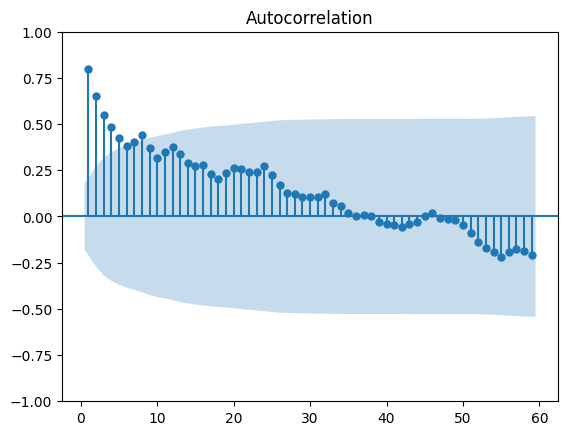

<Figure size 300x200 with 0 Axes>

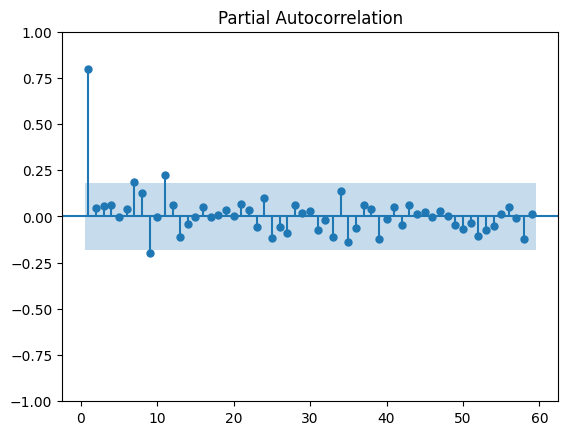

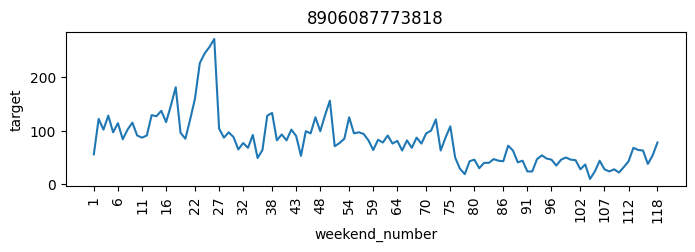

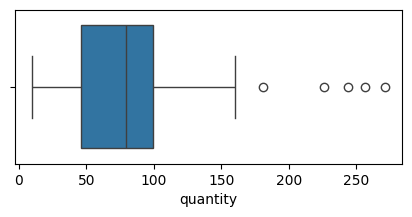


Some Transformation is required.. Trying differencing method on data
*** It is a Stationary Data ( P-value is 2.3660069335056123e-05 ) ***
Data is ready for Model Building


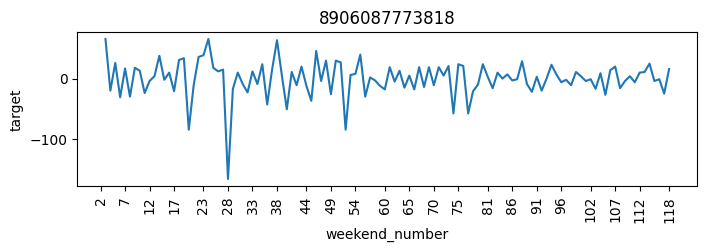

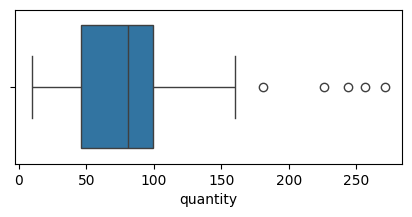

____________________________________________________________________________________________________
product is 8904417301076
start_date =  2022-07-30 00:00:00
End_date =  2024-08-31 00:00:00
(110, 10)
It is a non-stationary data ( P-value is 0.18687245884209097 )


<Figure size 300x200 with 0 Axes>

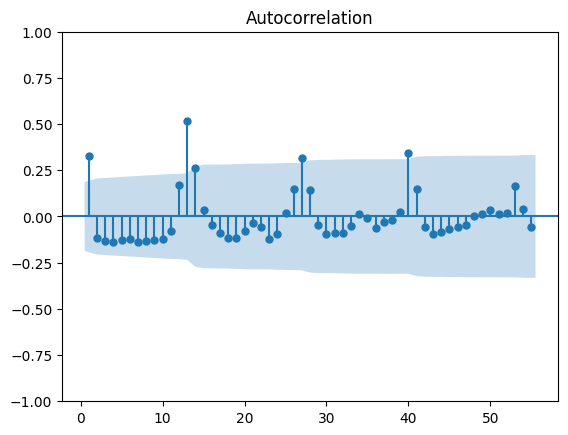

<Figure size 300x200 with 0 Axes>

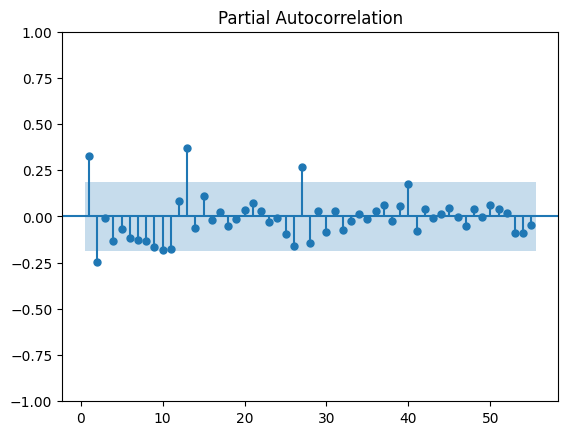

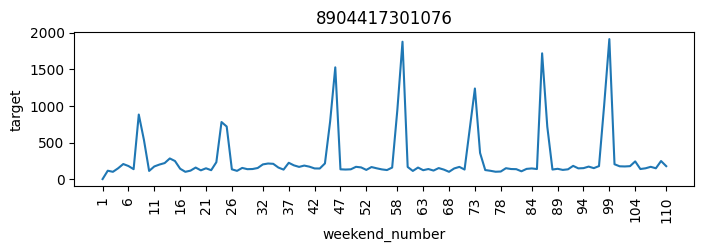

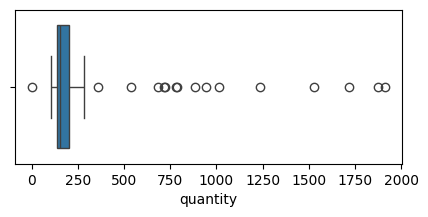


Some Transformation is required.. Trying differencing method on data
*** It is a Stationary Data ( P-value is 1.9124408236403127e-09 ) ***
Data is ready for Model Building


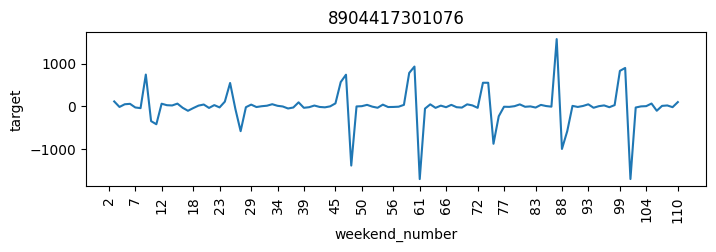

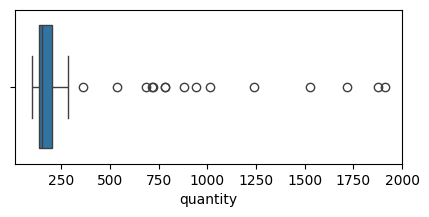

____________________________________________________________________________________________________
product is 8904417301106
There are missing values, added 2 row in dataframe
start_date =  2022-08-13 00:00:00
End_date =  2024-08-31 00:00:00
(108, 10)
*** It is a Stationary Data ( P-value is 1.2997513772351535e-12 ) ***
Data is ready for Model Building


<Figure size 300x200 with 0 Axes>

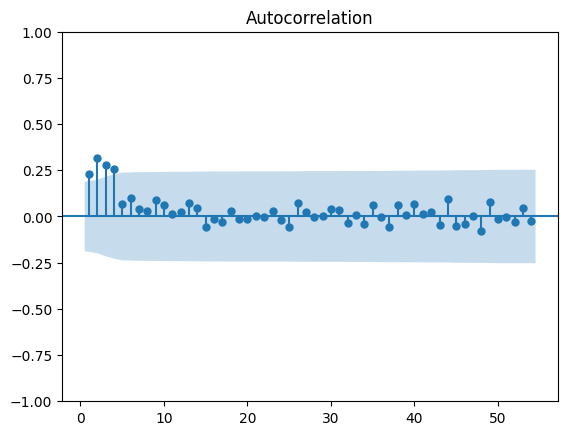

<Figure size 300x200 with 0 Axes>

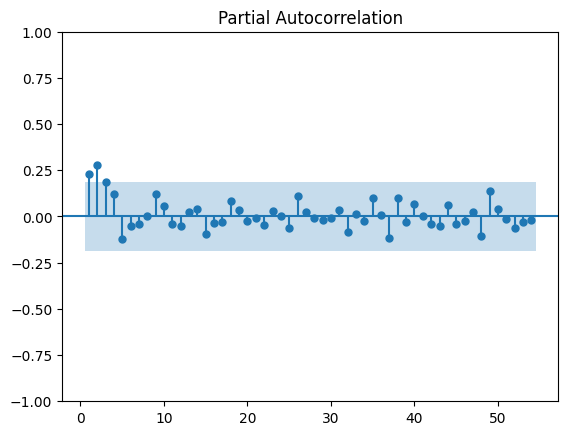

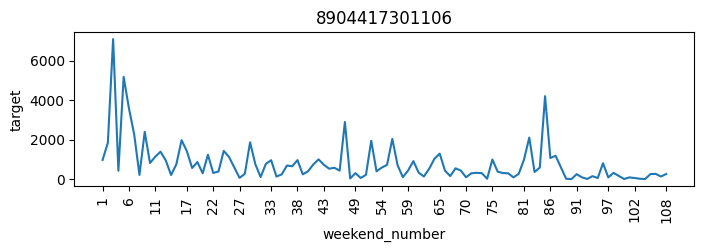

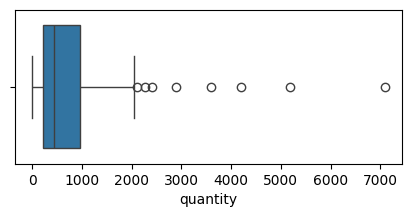

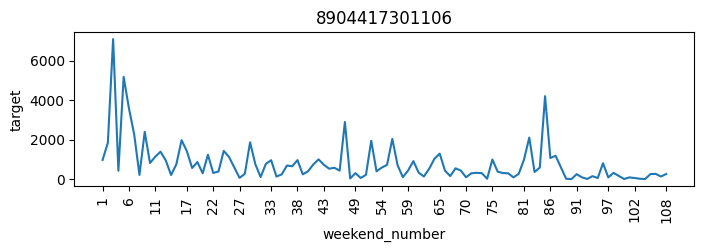

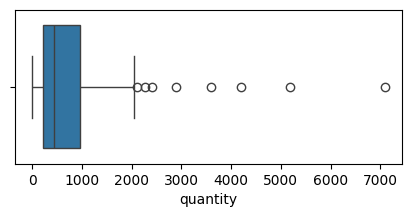

____________________________________________________________________________________________________
product is 8904417305838
start_date =  2023-01-21 00:00:00
End_date =  2024-08-31 00:00:00
(85, 10)
*** It is a Stationary Data ( P-value is 2.6335390001547012e-08 ) ***
Data is ready for Model Building


<Figure size 300x200 with 0 Axes>

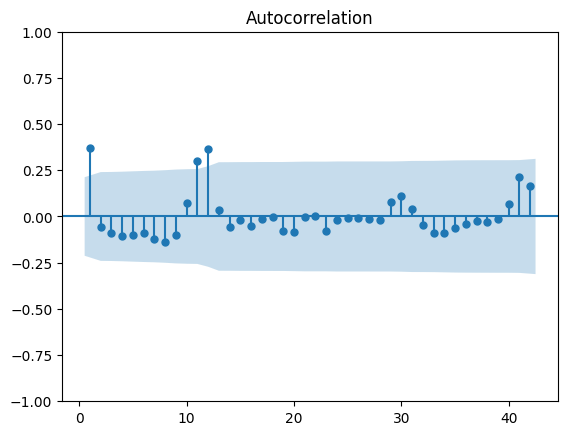

<Figure size 300x200 with 0 Axes>

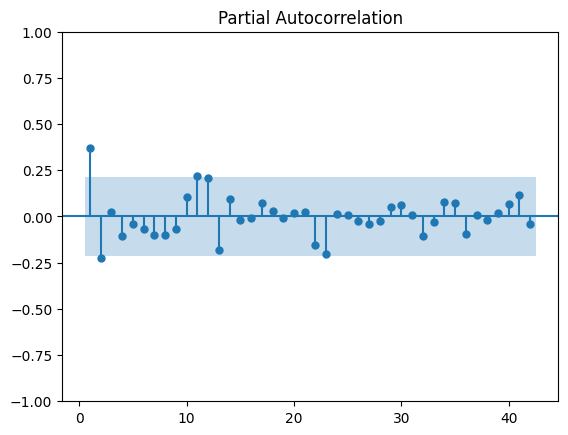

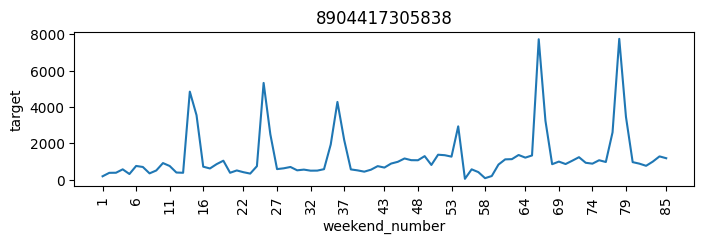

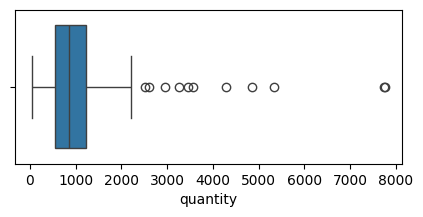

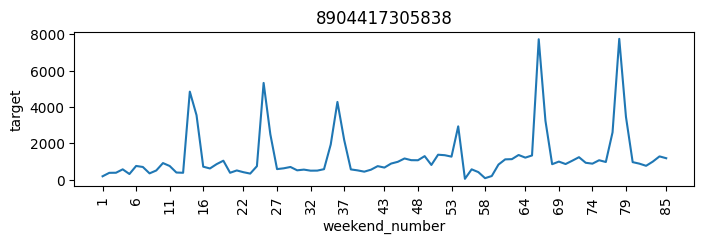

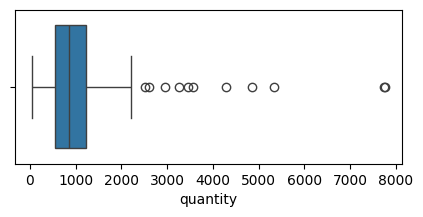

____________________________________________________________________________________________________
product is 8904417306248
start_date =  2023-04-22 00:00:00
End_date =  2024-08-31 00:00:00
(72, 10)
It is a non-stationary data ( P-value is 0.5644887554889002 )


<Figure size 300x200 with 0 Axes>

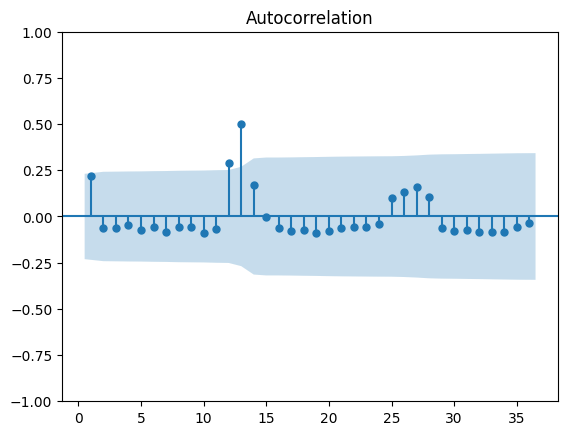

<Figure size 300x200 with 0 Axes>

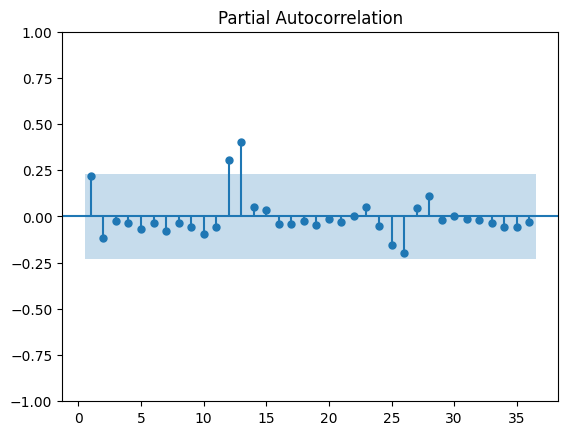

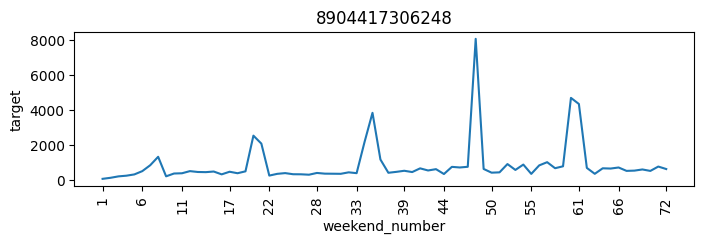

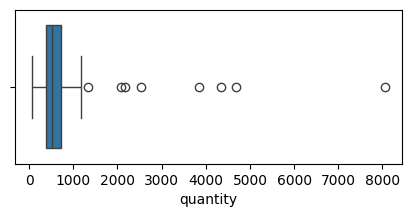


Some Transformation is required.. Trying differencing method on data
*** It is a Stationary Data ( P-value is 4.620350953263966e-09 ) ***
Data is ready for Model Building


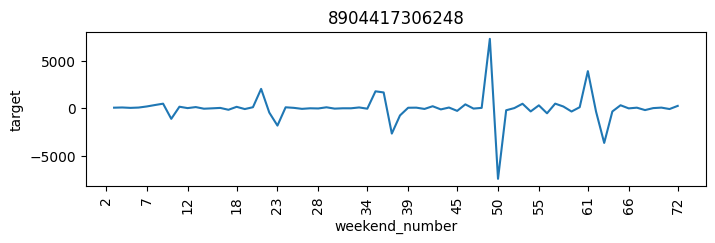

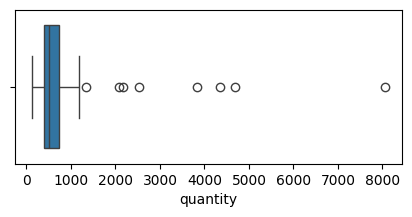

____________________________________________________________________________________________________


In [139]:
products = {}


for product_id in df['EAN'].unique():
    is_stationary = False
    # product_id = 8906087773818
    print(f'product is {product_id}')

    small_df = create_small_dataframe(df, product_id)
    print(small_df.shape)
    is_stationary = ADF_test(small_df['quantity'], is_stationary)
    small_df['target'] = small_df['quantity']
    acf_and_pacf(small_df)
    visualize(small_df)
    
    method = None
    if is_stationary == False:
        for method in ['differencing', 'log_differencing']: 
            print(f'\nSome Transformation is required.. Trying {method} method on data')
            stationary_data, is_stationary = make_stationary(small_df[['quantity']], method, is_stationary)
            if is_stationary:
                break
        small_df = small_df.iloc[1:]
        small_df = small_df.reset_index(drop=True)
        small_df['target'] = stationary_data
        
    visualize(small_df)
    products[product_id] = {
        'small_df': small_df,
        's_values': [], # customized as per product later
        'order': (0,0,0),  # Updated by best estimator
        'seasonal_order': (0,0,0,0), # Updated by best estimator
        'method': method,
    }
    
    small_df.set_index('weekend_date', inplace=True)

    print("__" * 50)

    # break


## Insights:  
- There are 6 unique products in the dataset, each having different seasonality and trend.  
- Identifying 6 different time series pattern is more accurate than identifying overall one single pattern.  
- Divided the dataset into small datasets based on unique product id i.e. "EAN".  
- These products are stationary and non-stationary. 
- Identified stationarity of the product using augmented Dickey–Fuller test (ADF).  
- Applied 1st order differentiation on non-stationary data, to make it stationary.  
- Once it is confirmed that data is stationary, then only SARIMAX model applied to understand the pattern.  


## Observation from the plots:  
1. Product : 8906087779247
- 


In [135]:
def find_best_estimators(attribs):
    small_df = attribs['small_df']
    p_values = d_values = q_values = range(0, 3)  # Example ranges
    P_values = D_values = Q_values = range(0, 2)
    s_values = attribs['s_values'] #seasonal period for weekly data

    best_order = None
    best_seasonal_order = None
    train_df, test_df = split_train_test(small_df, NUM_LAST_MONTHS)
    best_acc = -1 * float("inf")

    print('we are here')
    for p, d, q, P, D, Q, s in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        print('trying .. ', p, d, q, P, D, Q, s)
        try:
            model = SARIMAX(train_df['target'], order=(p, d, q), seasonal_order=(P, D, Q, s))
            results = model.fit(disp=False)

        except:
            print('raised exception, continueing')
            
        finally:
            # test data
            forecast = results.get_forecast(steps=test_df.shape[0])
            test_df['predictions'] = forecast.predicted_mean
            monthly_acc = get_monthly_accuracy(test_df)
            acc = monthly_acc['accuracy'].sum()

            if acc > best_acc:
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, s)
                best_acc = acc

    print(f"Best Order: {best_order}")
    print(f"Best Seasonal Order: {best_seasonal_order}")

    attribs['order'] = best_order
    attribs['seasonal_order'] = best_seasonal_order


### Customization

In [136]:
NUM_LAST_MONTHS = 3
# Based on manual inspection of graphs, decide the seasonality for different products
products[8906087779247]['s_values'] = [10,11, 12, 52]
products[8904417301076]['s_values'] = [15, 16, 17, 52]
products[8904417305838]['s_values'] = [10,11, 52]
products[8904417306248]['s_values'] = [14, 15, 52]
products[8906087773818]['s_values'] = [52]
products[8904417301106]['s_values'] = [52]

products[8906087779247]['order'] = (0,0,2)
products[8904417301076]['order'] = (0, 2, 0)
products[8904417305838]['order'] = (1, 2, 0)
products[8904417306248]['order'] = (1, 1, 2)
products[8906087773818]['order'] = (2,2,0)
products[8904417301106]['order'] = (0,0,2)

products[8906087779247]['seasonal_order'] = (0,0,0,10)
products[8904417301076]['seasonal_order'] = (1,0,0,17)
products[8904417305838]['seasonal_order'] = (0,0,1,11)
products[8904417306248]['seasonal_order'] = (1,1,0,52)
products[8906087773818]['seasonal_order'] = (0,0,0,52)
products[8904417301106]['seasonal_order'] = (1,0,0,52)


In [137]:
for product_id in products.keys():
    print("*" * 10 , product_id, "*" * 10 )
    attribs = products[product_id]
    #TODO: find_best_estimators(attribs)
    train_df, test_df = split_train_test(attribs['small_df'], NUM_LAST_MONTHS)
    model = SARIMAX(train_df['target'], order=attribs['order'], seasonal_order=attribs['seasonal_order'])
    results = model.fit(disp=False)

    forecast = results.get_forecast(steps=test_df.shape[0])
    test_df['predictions'] = forecast.predicted_mean
    if attribs['method']:
        test_df = inverse_transform_pred(train_df, test_df)
    
    monthly_acc = get_monthly_accuracy(test_df)
    print(monthly_acc)

    # break

********** 8906087779247 **********
   month_number  total_qty  total_abs  total_pred_qty  accuracy  month  year
0         24294       15.0  14.992138        0.007862  0.000524      6  2024
1         24295        0.0   0.000000        0.000000       NaN      7  2024
2         24296        0.0   0.000000        0.000000       NaN      8  2024
********** 8906087773818 **********
   month_number  total_qty    total_abs  total_pred_qty  accuracy  month  year
0         24294      148.0   130.737254      211.385562  0.116640      6  2024
1         24295      165.0   500.268218      665.268218 -2.031929      7  2024
2         24296      297.0  1654.258776     1951.258776 -4.569895      8  2024
********** 8904417301076 **********
   month_number  total_qty    total_abs  total_pred_qty  accuracy  month  year
0         24294     3488.0  2916.802529     1701.208739  0.163761      6  2024
1         24295      742.0  2842.453824     3584.453824 -2.830800      7  2024
2         24296      903.0  811

In [ ]:
products[8906087779247]['small_df']

In [138]:
abs(-5)

5

## Forecast for next 3 months

In [140]:
def sarimax_pred_for_sep2nov(small_df, sarimax_order, sarimax_seasonal_order, forecast_weeks=13):
    sarimax_model = SARIMAX(small_df['target'], order=sarimax_order, seasonal_order=sarimax_seasonal_order)
    sarimax_fit = sarimax_model.fit(disp=False)
    forecast = sarimax_fit.get_forecast(steps=forecast_weeks).predicted_mean

    start_date = forecast.index[0]
    date_index = pd.date_range(start=start_date, periods=13, freq='W-SAT').date #W-SAT to start on a Saturday.
    forecast_df = pd.DataFrame(index=date_index, columns=['forecast'])
    forecast_df['forecast'] = forecast
    return forecast_df


def inverse_forecast(forecast_df, small_df):
    forecast_df['quantity'] = np.nan
    prev_qty = small_df.iloc[-1]['quantity']  # prev_qty is last qty of train data.
    for index, row in forecast_df.iterrows():
        forecast_df.loc[index, 'quantity'] = prev_qty + row['forecast']  
        prev_qty = forecast_df.loc[index, 'quantity']

    return forecast_df

In [142]:
attribs = products[8904417301076]
train_df, test_df = split_train_test(attribs['small_df'], NUM_LAST_MONTHS)
pred = sarimax_pred_for_sep2nov(train_df, attribs['order'], attribs['seasonal_order'])
pred

,forecast
2024-06-01,0.0
2024-06-08,0.0
2024-06-15,0.0
2024-06-22,0.0
2024-06-29,0.0
2024-07-06,0.0
2024-07-13,0.0
2024-07-20,0.0
2024-07-27,0.0
2024-08-03,0.0


In [ ]:
forecast_df = pd.DataFrame({'EAN' : [],
                            'quantity': []})

for product_id in products.keys():
    # product_id = 8904417305838
    product_id = int(product_id)
    attribs = products[product_id]
    small_df = attribs['small_df'].copy()

    sarimax_order = attribs['order']
    sarimax_seasonal_order = attribs['seasonal_order'] 
    print(product_id, sarimax_order, sarimax_seasonal_order)
    # TODO: sarimax_order = (1,0,0)
    # TODO: sarimax_seasonal_order = (0,0,0,10)

    small_forecast_df = sarimax_pred_for_sep2nov(small_df, sarimax_order, sarimax_seasonal_order, forecast_weeks=13)
    if attribs['method']:
        small_forecast_df = inverse_forecast(small_forecast_df, small_df)
    else:
        small_forecast_df['quantity'] = small_forecast_df['forecast']
    small_forecast_df['EAN'] = product_id
    small_forecast_df = small_forecast_df.drop(['forecast'], axis=1)
    forecast_df = pd.concat([forecast_df, small_forecast_df], axis=0)

print(forecast_df)

In [ ]:
forecast_df

In [ ]:
int(product_id)

In [ ]:
for product_id in [8906087779247,
 8906087773818,
 8904417301076,
 8904417301106,
 8904417305838,
 8904417306248]:
    print(product_id)
    print(products[product_id])
    print("*" * 50)

In [ ]:
a = list(products.keys())
b = [int(p) for p in a]
b

In [ ]:
a = inverse_transform_pred_1(train_df, test_df)


In [ ]:
train_df.iloc[-1]['quantity']

In [ ]:
a

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm

def tune_sarimax(series, seasonal_period):
    """Tunes SARIMAX model using grid search and AIC."""

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]

    best_aic = float("inf")
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(series, order=param, seasonal_order=param_seasonal)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue

    return best_params

def sarimax_forecast(series, order, seasonal_order, forecast_steps):
    """Fits SARIMAX model and generates forecasts."""
    model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_values = forecast.predicted_mean
    return forecast_values

def auto_sarimax_forecast(series, seasonal_period, forecast_steps):
    """Fits SARIMAX model using auto_arima and generates forecasts."""
    model = pm.auto_arima(series, seasonal=True, m=seasonal_period, suppress_warnings=True)
    forecast = model.predict(n_periods=forecast_steps)
    return forecast

# Example usage (assuming your data is in 'sales_data.csv')
df = pd.read_csv('sales_data.csv')
df['weekend date'] = pd.to_datetime(df['weekend date'])
df.set_index('weekend date', inplace=True) #set index to date

# Example: Forecasting for a specific product ID
product_id = df['product ID'].unique()[0] #get first product ID
product_series = df[df['product ID'] == product_id]['quantity']

seasonal_period = 52  # Example: Weekly data with yearly seasonality

# 1. Tuning with Grid Search and AIC
best_params = tune_sarimax(product_series, seasonal_period)
if best_params:
    order, seasonal_order = best_params
    print(f"Best SARIMAX parameters (Grid Search): order={order}, seasonal_order={seasonal_order}")

    # Split data for evaluation
    train_size = int(len(product_series) * 0.8)
    train, test = product_series[:train_size], product_series[train_size:]
    forecast_steps = len(test)

    # Forecast and evaluate
    forecast_values = sarimax_forecast(train, order, seasonal_order, forecast_steps)
    mae = mean_absolute_error(test, forecast_values)
    print(f"SARIMAX MAE (Grid Search): {mae}")

# 2. Tuning with auto_arima
    forecast_values_auto = auto_sarimax_forecast(train, seasonal_period, forecast_steps)
    mae_auto = mean_absolute_error(test, forecast_values_auto)
    print(f"SARIMAX MAE (auto_arima): {mae_auto}")

else:
    print("SARIMAX tuning failed.")

#Example of how to run this for all product IDs.
product_ids = df['product ID'].unique()

for product_id in product_ids:
    product_series = df[df['product ID'] == product_id]['quantity']

    best_params = tune_sarimax(product_series, seasonal_period)

    if best_params:
      order, seasonal_order = best_params
      print(f"Best SARIMAX parameters (Grid Search) for product {product_id}: order={order}, seasonal_order={seasonal_order}")

      train_size = int(len(product_series) * 0.8)
      train, test = product_series[:train_size], product_series[train_size:]
      forecast_steps = len(test)

      forecast_values = sarimax_forecast(train, order, seasonal_order, forecast_steps)
      mae = mean_absolute_error(test, forecast_values)
      print(f"SARIMAX MAE (Grid Search) for product {product_id}: {mae}")
    else:
      print(f"SARIMAX tuning failed for product {product_id}.")

In [ ]:
df.head()

In [ ]:
sns.lineplot(data=df[df['EAN'] == 8906087779247], x = 'weekend_date', y = 'quantity', color='b')
sns.lineplot(data=df[df['EAN'] == 8906087773818], x = 'weekend_date', y = 'quantity', color='r')

In [ ]:
plt.figure(figsize=(15, 10))
for product_id in df['EAN'].unique():
    sns.lineplot(data=df[df['EAN'] == product_id], x = 'weekend_date', y = 'quantity', color='b')

plt.show()

## Practice code

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Simulate realistic monthly sales data for a retail store
np.random.seed(42)  # For reproducibility

dates = pd.date_range(start='2018-01-01', end='2023-12-31', freq='MS')
years = dates.year
months = dates.month

In [ ]:
# Base sales with an upward trend
base_sales = 500 + 10 * (years - 2018) + np.random.normal(0, 50, len(dates))
base_sales
# Seasonal component (holiday spikes, summer dip)
seasonal_component = 200 * np.sin(2 * np.pi * months / 12) + 100 * np.sin(2 * np.pi * (months % 12) / 6) + np.random.normal(0, 30, len(dates))

# Random fluctuations
noise = np.random.normal(0, 80, len(dates))

# Final sales data
retail_sales = base_sales + seasonal_component + noise


In [ ]:
# Create DataFrame
data = pd.DataFrame({'sales': retail_sales}, index=dates)

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Retail Sales')
plt.legend()
plt.title('Retail Sales Over Time')
plt.show()

In [ ]:
# Decompose the time series
decomposition = seasonal_decompose(data['sales'], model='additive')
decomposition.plot()
plt.show()


In [ ]:
# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [ ]:
# Fit SARIMA model (parameter tuning is crucial)
# Example parameters. In real world, use auto_arima or grid search.
model = sm.tsa.SARIMAX(train['sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

In [ ]:
# Generate forecasts
forecast = results.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

In [ ]:
# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train['sales'], label='Train')
plt.plot(test['sales'], label='Test')
plt.plot(test.index, forecast_values, label='Forecast', color='red')
plt.fill_between(test.index, confidence_intervals[:, 0], confidence_intervals[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('SARIMA Forecast vs. Actual Sales')
plt.show()

In [ ]:
# Evaluate the model (RMSE)
rmse = np.sqrt(mean_squared_error(test['sales'], forecast_values))
print(f'RMSE: {rmse}')

#Print model summary.
print(results.summary())

# Example of forecasting future values (beyond the test set)
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='MS')
future_forecast = results.get_forecast(steps=len(future_dates))
future_forecast_values = future_forecast.predicted_mean
future_confidence_intervals = future_forecast.conf_int()

# Plot future forecasts
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Historical Sales')
plt.plot(future_dates, future_forecast_values, label='Future Forecast', color='green')
plt.fill_between(future_dates, future_confidence_intervals[:, 0], future_confidence_intervals[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title('SARIMA Future Forecast')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Assuming your data is in a CSV file named 'sales_data.csv'
df = pd.read_csv('sales_data.csv')

# 1. Data Understanding and Preparation
# Convert 'weekend date' to datetime
df['weekend date'] = pd.to_datetime(df['weekend date'])

# EDA (Example: Plotting quantity over time for a specific product)
product_id = df['product ID'].unique()[0]  # Example: first product
product_df = df[df['product ID'] == product_id].sort_values('weekend date')
plt.figure(figsize=(12, 6))
plt.plot(product_df['weekend date'], product_df['quantity'])
plt.title(f'Quantity over Time for Product {product_id}')
plt.xlabel('Weekend Date')
plt.ylabel('Quantity')
plt.show()

# Feature Engineering
df['year'] = df['weekend date'].dt.year
df['month'] = df['weekend date'].dt.month
df['dayofweek'] = df['weekend date'].dt.dayofweek

# Lagged features (example: lag of 1 week)
df['quantity_lag1'] = df.groupby(['channel', 'brand', 'category', 'product ID'])['quantity'].shift(1)
df.dropna(inplace=True) #remove the first week of each group due to the shift.

# Categorical Encoding (One-Hot Encoding)
categorical_cols = ['channel', 'brand', 'category', 'product ID']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(df[categorical_cols]))
encoded_cols.columns = encoder.get_feature_names_out(categorical_cols)
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_cols], axis=1)

# Data Splitting (Chronological Split)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# Prepare features and target
features = [col for col in df.columns if col not in ['weekend date', 'quantity']]
target = 'quantity'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# 2. Model Selection and Training (Example: Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Model Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Example using Prophet model for one specific series.
# Prepare dataframe for prophet
prophet_df = product_df[['weekend date', 'quantity']].rename(columns={'weekend date': 'ds', 'quantity': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test[test['product ID_product 2.0'] == 1]), freq='W') #Example product ID_product 2.0
forecast = prophet_model.predict(future)

# Example of how to get the correct forecast period.
test_prophet = test[test['product ID_product 2.0'] == 1]
prophet_forecast_needed = forecast[forecast['ds'].isin(test_prophet['weekend date'])]
prophet_y_pred = prophet_forecast_needed['yhat'].values
prophet_y_test = test_prophet['quantity'].values

prophet_mae = mean_absolute_error(prophet_y_test, prophet_y_pred)
print(f"Prophet MAE: {prophet_mae}")

# Example ARIMA model (for one series)
product_series = product_df['quantity'].values
arima_model = ARIMA(product_series, order=(5, 1, 0)) #example order
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test[test['product ID_product 2.0'] == 1]))

arima_mae = mean_absolute_error(test_prophet['quantity'], arima_forecast)
print(f"ARIMA MAE: {arima_mae}")

# Further steps:
# - Implement time series cross-validation.
# - Experiment with other models (SARIMA, LSTM, XGBoost, etc.).
# - Fine-tune hyperparameters.
# - Handle multi-series forecasting more comprehensively.